<a href="https://colab.research.google.com/github/Saha-Manav/Lung-Cancer-Classification-Research-/blob/main/LC_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set paths
dataset_dir = '/content/drive/My Drive/Lung Cancer ML Project/IQ-OTHNCCD lung cancer dataset'  # Replace with your dataset path

# Create ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [ ]:
# Load ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Set up callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=10
    # callbacks=[early_stopping, checkpoint]
)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 508s 15s/step - accuracy: 0.4679 - loss: 1.0700 - val_accuracy: 0.4948 - val_loss: 1.0155
Epoch 2/10
 1/27 ━━━━━━━━━━━━━━━━━━━━ 3:16 8s/step - accuracy: 0.5000 - loss: 0.9959

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 0.5000 - loss: 0.9959 - val_accuracy: 0.6296 - val_loss: 0.8994
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 293s 9s/step - accuracy: 0.5274 - loss: 0.9422 - val_accuracy: 0.5677 - val_loss: 0.9640
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 183ms/step - accuracy: 0.4688 - loss: 0.9310 - val_accuracy: 0.5556 - val_loss: 0.8839
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 238s 9s/step - accuracy: 0.5467 - loss: 0.8987 - val_accuracy: 0.5104 - val_loss: 0.9290
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.3750 - loss: 1.0418 - val_accuracy: 0.3333 - val_loss: 1.1677
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 244s 8s/step - accuracy: 0.5910 - loss: 0.8648 - val_accuracy: 0.5104 - val_loss: 0.9961
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 181ms/step - accuracy: 0.5000 - loss: 1.1135 - val_accuracy: 0.4815 - val_loss: 0.8087
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 242s 9s/step - accuracy: 0.5673 - loss: 0.8835 - val_accuracy: 0.5312 - val_

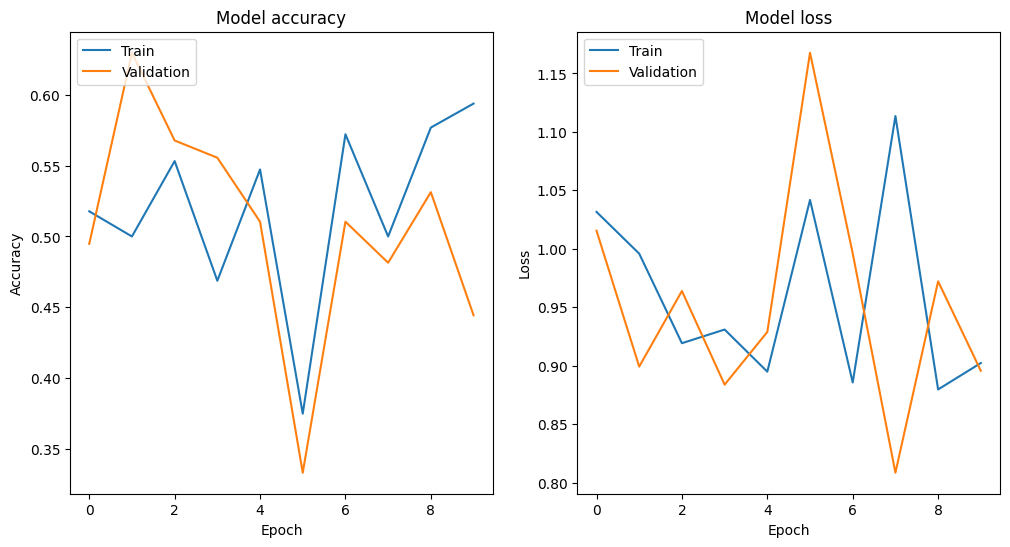

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
# Load the best model
#model.load_weights('best_model.h5')

# Predict on the validation set
valid_generator.reset()
predictions = model.predict(valid_generator, steps=valid_generator.samples // valid_generator.batch_size + 1)

# Get the predicted class labels
y_pred = np.argmax(predictions, axis=1)
y_true = valid_generator.classes
class_labels = list(valid_generator.class_indices.keys())


7/7 ━━━━━━━━━━━━━━━━━━━━ 54s 7s/step


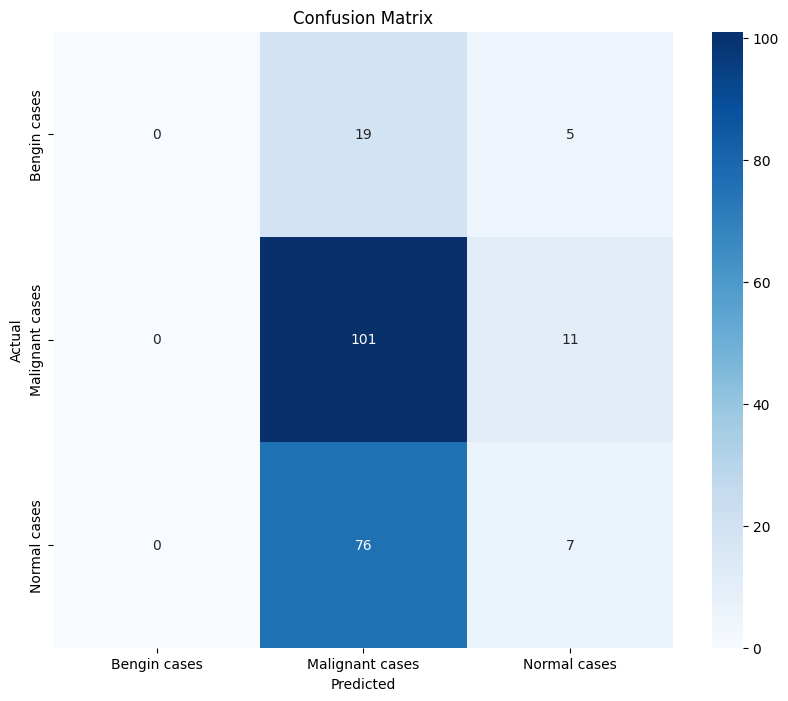

Classification Report
                 precision    recall  f1-score   support

   Bengin cases       0.00      0.00      0.00        24
Malignant cases       0.52      0.90      0.66       112
   Normal cases       0.30      0.08      0.13        83

       accuracy                           0.49       219
      macro avg       0.27      0.33      0.26       219
   weighted avg       0.38      0.49      0.39       219



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_labels))


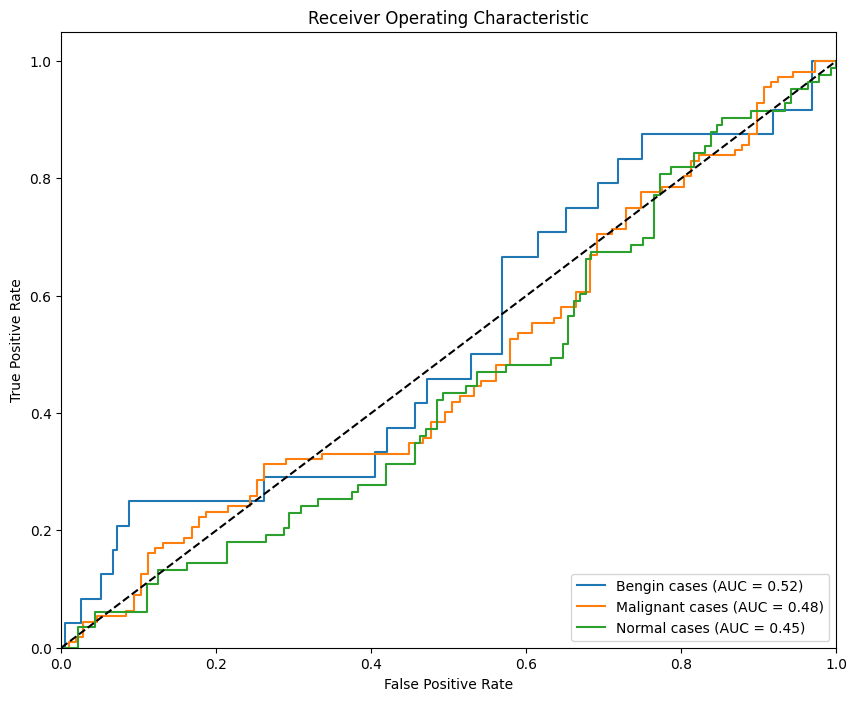

In [ ]:
# ROC Curve and AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(valid_generator.classes, predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
